# FarmVibes.AI Crop Segmentation - Data Exploration

This notebook provides a self-contained workspace for visualizing and exploring the outputs of the dataset generation workflow for the crop segmentation task. 

We run a workflow that exposes the intermediate outputs of the dataset generation workflow, allowing us to visualize Sentinel-2 data, NDVI rasters and [Crop Data Layer](https://data.nal.usda.gov/dataset/cropscape-cropland-data-layer#:~:text=The%20Cropland%20Data%20Layer%20%28CDL%29%2C%20hosted%20on%20CropScape%2C,as%20well%20as%20boundary%2C%20water%20and%20road%20layers.) (CDL) maps provided by the FarmVibes.AI platform.


### Conda environment setup
Before running this notebook, let's build a conda environment. If you do not have conda installed, please follow the instructions from [Conda User Guide](https://docs.conda.io/projects/conda/en/latest/user-guide/index.html). 

```
$ conda env create -f ./crop_env.yaml
$ conda activate crop-seg
```

------------------------

### Imports and utility methods

In [1]:
# Utility imports
from datetime import datetime
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import rasterio
from rasterio.warp import reproject 
from rasterio.mask import mask
import yaml
import json
from copy import deepcopy

# FarmVibes.AI imports
from vibe_core.client import get_default_vibe_client
from notebook_lib.constants import CROP_INDICES
from notebook_lib.utils import lw_plot

/home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/azureuser/anaconda3/envs/crop-seg/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


### Utility methods

In [2]:
def transparent_cmap(cmap, max_alpha=0.8, N=255):
    "Copy colormap and set alpha values"
    mycmap = deepcopy(cmap)
    mycmap._init()  # type: ignore
    mycmap._lut[:, -1] = np.linspace(0, max_alpha, N + 4)  # type: ignore
    return mycmap

def s2_to_img(ar, rgb_idx=[3, 2, 1]):
    return (ar[rgb_idx] / 10000).clip(0, .3).transpose((1, 2, 0)) / .3

def read_raster(raster, geometry=None, window=None, **kwargs):
    with rasterio.open(raster.raster_asset.url, **kwargs) as src:
        if geometry is not None:
            return mask(src, [geometry], crop=True, **kwargs)[0]
        return src.read(window=window)

### Retrieve the dataset with FarmVibes.AI platform

We will retrieve the dataset from FarmVibes.AI cache by running a custom version of the `ml/dataset_generation/datagen_crop_segmentation` workflow that exposes the intermediate outputs (Sentinel-2 images, cloud and shadow mask, SpaceEye outputs) along with the NDVI rasters and CDL maps.

In [3]:
client = get_default_vibe_client()

input_geometry_path = "./input_region.wkt"
time_range = (datetime(2020, 1, 1), datetime(2020, 12, 31))

# Reading the geometry file 
with open(input_geometry_path) as f:
    geometry = wkt.load(f)

# Reading the workflow
with open("wf_viz_crop_seg.yaml") as f:
    wf_dict = yaml.safe_load(f)

wf_run = client.run(wf_dict, "Crop Segmentation Workflow Visualization", geometry=geometry, time_range=time_range)
wf_run.monitor()

Output()

Recovering the workflow outputs:

In [4]:
s2_rasters = wf_run.output["s2_rasters"]
s2_masks = wf_run.output["s2_masks"]
se_rasters = wf_run.output["se_rasters"]
ndvi_rasters = wf_run.output["ndvi"]
cdl_rasters = wf_run.output["cdl"]

print(f"# of Sentinel-2 rasters: {len(s2_rasters)}")
print(f"# of cloud and shadow masks: {len(s2_masks)}")
print(f"# of SpaceEye rasters: {len(se_rasters)}")
print(f"# of NDVI rasters: {len(ndvi_rasters)}")
print(f"# of CDL maps: {len(cdl_rasters)}")

# of Sentinel-2 rasters: 72
# of cloud and shadow masks: 72
# of SpaceEye rasters: 366
# of NDVI rasters: 366
# of CDL maps: 1


## Data Exploration

Let's select one Sentinel-2 raster and visualize it, along with the respective cloud and shadow mask and SpaceEye output.
You can select other images by changing `select_idx` (between `0`  and `len(s2_rasters)`):

In [5]:
select_idx = 20
select_idx = min(max(0, select_idx), len(s2_rasters)-1)

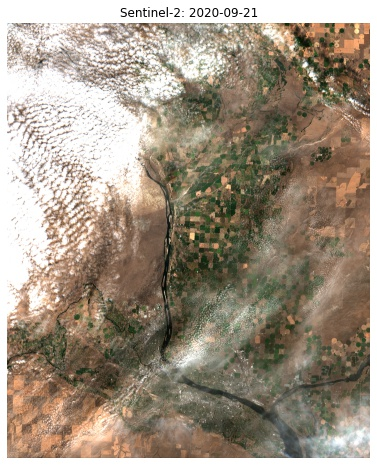

In [6]:
s2 = s2_rasters[select_idx]

# Retrieve the projection geometry for the raster
with rasterio.open(s2_rasters[0].raster_asset.url) as src:
    proj_geom = gpd.GeoSeries(geometry, crs="epsg:4326").to_crs(src.crs).iloc[0].envelope


with rasterio.open(s2.raster_asset.url) as src:
    s2_ar = read_raster(s2, geometry=proj_geom)
    plt.figure(figsize=(8, 8))
    plt.title(f"Sentinel-2: {s2.time_range[0].strftime('%Y-%m-%d')}")
    plt.imshow(s2_to_img(s2_ar))
    plt.axis("off")
    lw_plot()

Retrieving the cloud and shadow mask for the same date:

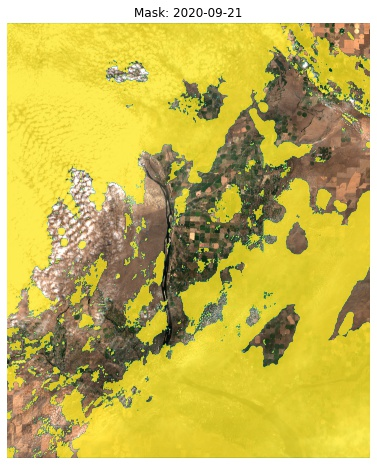

In [7]:
cloud_mask = [m for m in s2_masks if m.time_range[0].day == s2.time_range[0].day and m.time_range[0].month == s2.time_range[0].month][0]

cloud_ar = read_raster(cloud_mask, geometry=proj_geom)
cloud_ar[cloud_ar == 100] = 0

plt.figure(figsize=(8, 8))
plt.imshow(s2_to_img(s2_ar))
plt.imshow(cloud_ar[0], cmap=transparent_cmap(plt.cm.viridis))
plt.title(f"Mask: {cloud_mask.time_range[0].strftime('%Y-%m-%d')}")
plt.axis("off")
lw_plot()



And, finally, retrieve the SpaceEye output associated with them:

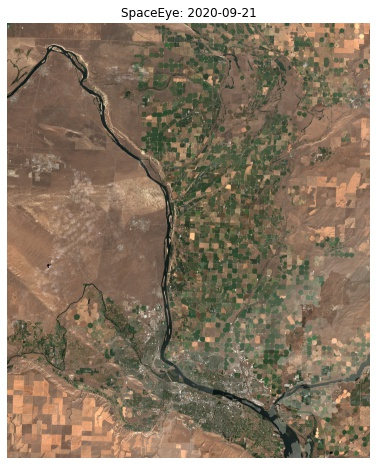

In [8]:
spaceeye = [se for se in se_rasters if se.time_range[0].day == s2.time_range[0].day and se.time_range[0].month == s2.time_range[0].month][0]

with rasterio.open(spaceeye.raster_asset.url) as src:
    se_ar = src.read()
    plt.figure(figsize=(8, 8))
    plt.title(f"SpaceEye: {spaceeye.time_range[0].strftime('%Y-%m-%d')}")
    plt.imshow(s2_to_img(se_ar, rgb_idx = [2,1,0]))
    plt.axis("off")
    lw_plot()

Side-by-side comparison:

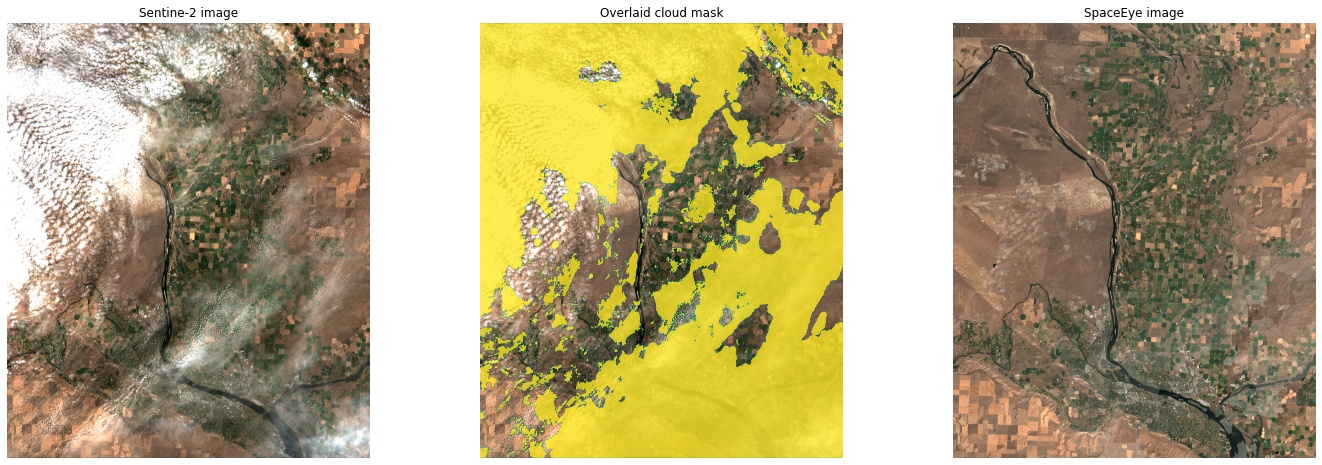

In [9]:
plt.figure(figsize=(24, 8))

plt.subplot(1, 3, 1)
plt.imshow(s2_to_img(s2_ar))
plt.title("Sentine-2 image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(s2_to_img(s2_ar))
plt.imshow(cloud_ar[0], cmap=transparent_cmap(plt.cm.viridis))
plt.title("Overlaid cloud mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(s2_to_img(se_ar, rgb_idx = [2,1,0]))
plt.title("SpaceEye image")
plt.axis("off")

lw_plot()   

To get a better sense of the differences between Sentinel-2 and SpaceEye images, let's view a few of them side by side:

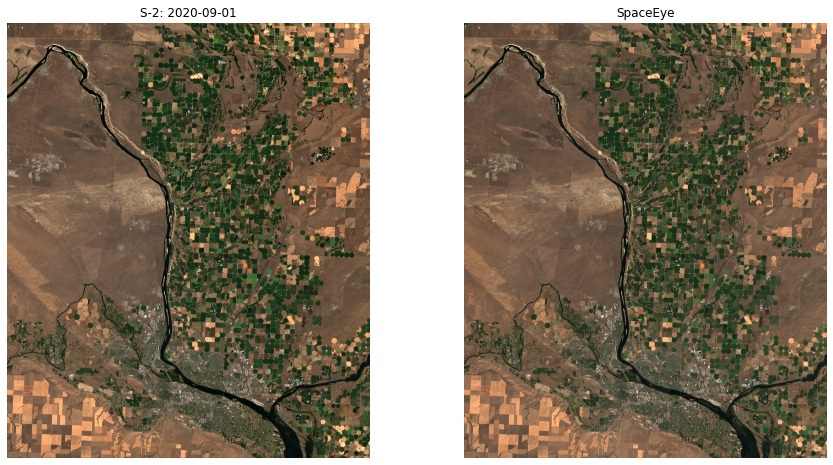

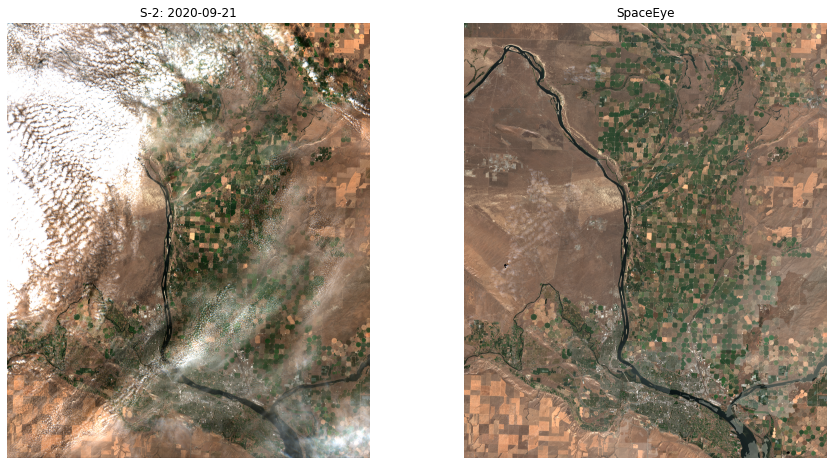

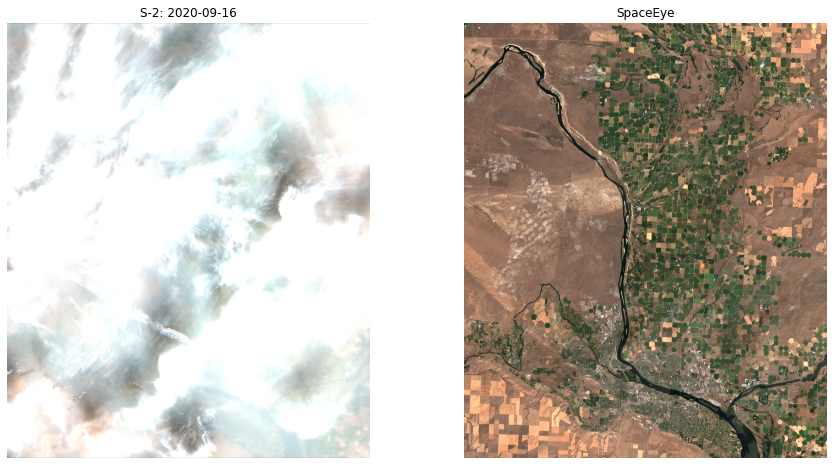

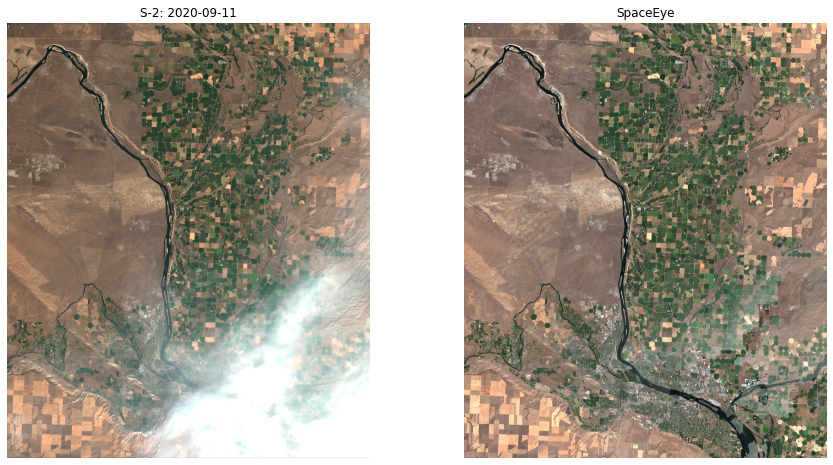

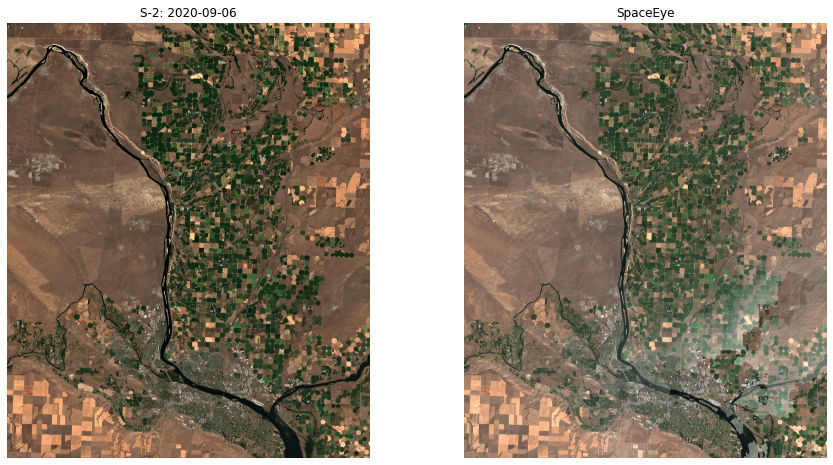

In [10]:
n_imgs_to_show = 5
top_idx = min(select_idx + n_imgs_to_show, len(s2_rasters)-1)
 
for s2 in s2_rasters[select_idx:top_idx]:
    plt.figure(figsize=(15, 8))
    se_raster = sorted(se_rasters, key=lambda x: abs(s2.time_range[0] - x.time_range[0]))[0]
    plt.subplot(1, 2, 1)
    plt.title(f"S-2: {s2.time_range[0].strftime('%Y-%m-%d')}")
    plt.imshow(s2_to_img(read_raster(s2, geometry=proj_geom)))
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(s2_to_img(read_raster(se_raster), rgb_idx=[2, 1, 0]))
    plt.title("SpaceEye")
    plt.axis("off")
lw_plot()

The workflow computes the NDVI over the cloud-free image from SpaceEye:

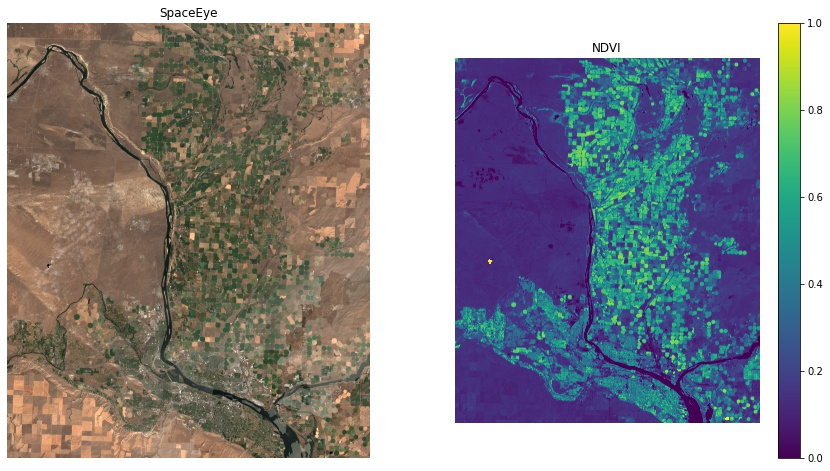

In [11]:
ndvi = [nd for nd in ndvi_rasters if nd.time_range[0].day == spaceeye.time_range[0].day and nd.time_range[0].month == spaceeye.time_range[0].month][0]
with rasterio.open(ndvi.raster_asset.url) as src:
    ndvi_ar = src.read()


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(s2_to_img(se_ar, rgb_idx = [2,1,0]))
plt.title("SpaceEye")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ndvi_ar[0,:,:],vmin=0,vmax=1)
plt.title("NDVI")
plt.colorbar()
plt.axis("off")
lw_plot()

### Exploring the CDL maps
Let's visualize the CDL map (with all crop indices colorized) and the binary (crop vs. non-crop) mask:

In [12]:
cdl = cdl_rasters[0]
vis_asset = cdl.visualization_asset
with open(vis_asset.local_path) as mtdt:
    metadata = json.load(mtdt)
    colormap = metadata["colormap"]

colormap = np.array(colormap) / 255.0
colormap = ListedColormap(colormap.tolist())

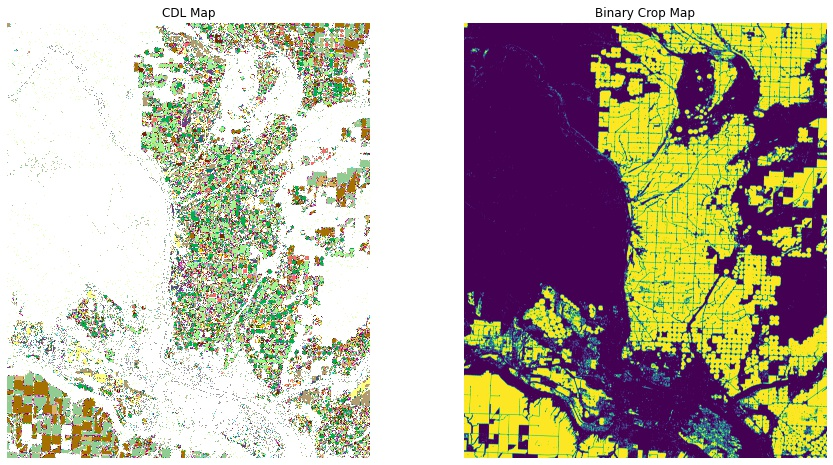

In [13]:
with rasterio.open(s2.raster_asset.url) as src:
    ar, tr = mask(src, [proj_geom], crop=True)
    cdl_ar = np.zeros_like(ar)
    with rasterio.open(cdl.raster_asset.url) as src_w:
        reproject(rasterio.band(src_w, 1), destination=cdl_ar, dst_transform=tr, dst_crs=src.crs)


plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(cdl_ar[0,:,:], cmap=colormap)
plt.title("CDL Map")
plt.axis("off")


binary_cdl = np.isin(cdl_ar, CROP_INDICES)
plt.subplot(1, 2, 2)
plt.imshow(binary_cdl[0,:,:])
plt.title("Binary Crop Map")
plt.axis("off")
lw_plot()